# CSV example

Obtain data from [https://www.ncei.noaa.gov/cdo-web/](https://www.ncei.noaa.gov/cdo-web/), for example the [daily summaries of the year 1949](https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_year/1949.csv.gz).
Note that this is a gzipped file. Pandas can deal with it.

The data file has 94 MBytes, it may be too large to import into Excel (or Excel may cut some lines).

In [31]:
import pandas as pd
from ftplib import FTP
import requests   # more convenient for http(s) urls

In [9]:
# download the file
url = "ftp://ftp.ncei.noaa.gov/pub/data/ghcn/daily/by_year/1949.csv.gz"
site, fpath = url.split("//")[1].split("/", 1)
fpath, fname = fpath.rsplit("/", 1)
print(f"site:{site}, fpath:{fpath}, fname:{fname}")
with FTP(site) as session:
    session.login()  # "anonymous", "your-email@uni-koeln.de")
    session.set_debuglevel(1)
    session.cwd(fpath)
    with open(fname, 'wb') as local_file:
        session.retrbinary(f"RETR {fname}", local_file.write)
    # also download the readme file that belongs to the daily summaries
    fname_readme = "readme-by_year.txt"
    with open(fname_readme, 'wb') as local_file:
        session.retrbinary(f"RETR {fname_readme}", local_file.write)
# if you don't use with ftp.FTP, you must call session.quit() to close the session


site:ftp.ncei.noaa.gov, fpath:pub/data/ghcn/daily/by_year, fname:1949.csv.gz
*cmd* 'CWD pub/data/ghcn/daily/by_year'
*resp* '250 CWD command successful'
*cmd* 'TYPE I'
*resp* '200 Type set to I'
*cmd* 'PASV'
*resp* '227 Entering Passive Mode (205,167,25,137,234,185).'
*cmd* 'RETR 1949.csv.gz'
*resp* '150 Opening BINARY mode data connection for 1949.csv.gz (98267990 bytes)'
*resp* '226 Transfer complete'
*cmd* 'TYPE I'
*resp* '200 Type set to I'
*cmd* 'PASV'
*resp* '227 Entering Passive Mode (205,167,25,137,255,159).'
*cmd* 'RETR readme-by_year.txt'
*resp* '150 Opening BINARY mode data connection for readme-by_year.txt (1106 bytes)'
*resp* '226 Transfer complete'
*cmd* 'QUIT'
*resp* '221 Goodbye.'


In [10]:
# download the documentation (general readme file and station list)
url = "ftp://ftp.ncei.noaa.gov/pub/data/ghcn/daily"
site, fpath = url.split("//")[1].split("/", 1)
with FTP(site) as session:
    session.login()  # "anonymous", "your-email@uni-koeln.de")
    session.set_debuglevel(1)
    session.cwd(fpath)
    fname = "readme.txt"
    with open(fname, 'wb') as local_file:
        session.retrbinary(f"RETR {fname}", local_file.write)
    fname = "ghcnd-stations.txt"
    with open(fname, 'wb') as local_file:
        session.retrbinary(f"RETR {fname}", local_file.write)


*cmd* 'CWD pub/data/ghcn/daily'
*resp* '250 CWD command successful'
*cmd* 'TYPE I'
*resp* '200 Type set to I'
*cmd* 'PASV'
*resp* '227 Entering Passive Mode (205,167,25,137,252,106).'
*cmd* 'RETR readme.txt'
*resp* '150 Opening BINARY mode data connection for readme.txt (28140 bytes)'
*resp* '226 Transfer complete'
*cmd* 'TYPE I'
*resp* '200 Type set to I'
*cmd* 'PASV'
*resp* '227 Entering Passive Mode (205,167,25,137,249,190).'
*cmd* 'RETR ghcnd-stations.txt'
*resp* '150 Opening BINARY mode data connection for ghcnd-stations.txt (10834968 bytes)'
*resp* '226 Transfer complete'
*cmd* 'QUIT'
*resp* '221 Goodbye.'


In [8]:
# Alternative: download the data file via requests
# works only if the site provides access via http(s)
url = "https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_year/1949.csv.gz"
response = requests.get(url)
if response.ok:
    filename = url.rsplit('/', 1)[1]
    print(f"data downloaded. Will be saved as {filename}")
    with open(filename, "wb") as f:
        f.write(response.content)
else:
    print("An error occured while trying to retrieve the data from the internet.")

data downloaded. Will be saved as 1949.csv.gz


In [32]:
# read data into pandas
filename = "1949.csv.gz"
# note that this takes a while, because the computer must translate text characters into numbers
columns = ["stationcode", "datelabel", "param", "value", "mflag", "qflag", "sflag", "time"]
df = pd.read_csv(filename, names=columns, compression="gzip")

# convert values to float
df = df.astype({"value": "float32"})
print(df)

          stationcode  datelabel param  value mflag qflag sflag  time
0         ACW00011604   19490101  TMAX  289.0   NaN   NaN     X   NaN
1         ACW00011604   19490101  TMIN  217.0   NaN   NaN     X   NaN
2         ACW00011604   19490101  PRCP    0.0   NaN   NaN     X   NaN
3         ACW00011604   19490101  SNOW    0.0   NaN   NaN     X   NaN
4         ACW00011604   19490101  SNWD    0.0   NaN   NaN     X   NaN
...               ...        ...   ...    ...   ...   ...   ...   ...
23787114  WZ004094600   19491231  PRCP    0.0   NaN   NaN     I   NaN
23787115  WZ004451000   19491231  PRCP    0.0   NaN   NaN     I   NaN
23787116  WZ004467410   19491231  PRCP  142.0   NaN   NaN     I   NaN
23787117  WZ004822290   19491231  PRCP    0.0   NaN   NaN     I   NaN
23787118  WZ004834260   19491231  PRCP  178.0   NaN   NaN     I   NaN

[23787119 rows x 8 columns]


In [41]:
# let's "calibrate" our variables. Units are provided in the readme file. 
# Luckily, values have been converted to float automatically.
# The following solution comes from the CoPilot
# Define custom scaling factors for each group
scaling_factors = {"TMIN": 0.1, "TMAX": 0.1, "PRCP": 0.1}

# Apply the scaling factors to the "value" column
# Note: this is incredibly slow (takes several minutes!)
df["value"] = df.apply(lambda row: row["value"] * scaling_factors.get(row["param"], 1.), axis=1)

# To calculate statistics on individual parameters, we use groupby
# A nice tutorial on groupby can be found at https://towardsdatascience.com/all-pandas-groupby-you-should-know-for-grouping-data-and-performing-operations-2a8ec1327b5
dfg = df.groupby(["param"])
print(dfg["value"].mean())

param
DAEV       2.877395
DAPR       2.975597
DASF       2.579710
DATN       2.125000
DATX       2.093633
DAWM       2.561644
DWPR       1.205707
EVAP      59.184877
FRGB       9.932258
FRGT       0.503226
FRTH       9.440705
GAHT    -225.191150
MDEV      80.206897
MDPR     213.986577
MDSF     122.223567
MDTN     120.050781
MDTX     262.550562
MDWM     188.006849
MXPN     406.000000
PGTM    1279.229827
PRCP       2.307418
SNOW       2.026315
SNWD      22.011722
TAVG      28.940919
THIC     683.303419
TMAX      17.330366
TMIN       4.641757
TOBS     123.943751
WDFG     202.217939
WDMV     121.043683
WSFG     111.517981
WT01       1.000000
WT03       1.000000
WT04       1.000000
WT05       1.000000
WT06       1.000000
WT07       1.000000
WT08       1.000000
WT09       1.000000
WT10       1.000000
WT11       1.000000
WT14       1.000000
WT16       1.000000
WT18       1.000000
Name: value, dtype: float64


In [33]:
# cleanse dataset: keep only the parameters of interest, i.e. TMIN, TMAX, PRCP, SNOW
keep = ["TMIN", "TMAX", "PRCP", "SNOW"]
df = df[df["param"].isin(keep)]

In [34]:
# let's "calibrate" our variables. Units are provided in the readme file. 
# Luckily, values have been converted to float automatically.
# The following solution comes from the CoPilot
# Define custom scaling factors for each group
scaling_factors = {"TMIN": 0.1, "TMAX": 0.1, "PRCP": 0.1}

# Apply the scaling factors to the "value" column
# Note: this is much faster than the apply version above!
for k, v in scaling_factors.items():
    df.loc[df["param"]==k,"value"] *= v

# To calculate statistics on individual parameters, we use groupby
# A nice tutorial on groupby can be found at https://towardsdatascience.com/all-pandas-groupby-you-should-know-for-grouping-data-and-performing-operations-2a8ec1327b5
dfg = df.groupby(["param"])
print(dfg["value"].mean())

param
PRCP     2.307418
SNOW     2.026315
TMAX    17.330366
TMIN     4.641757
Name: value, dtype: float32


In [35]:
# read station metadata
# This is a fixed widths file, so we use pandas.read_fwf instead of read_csv
# Column widths will be determined from the first 500 lines
columns = ["code", "lat", "lon", "elevation", "state", "name", "flag1", "flag2", "wmo_id"]
stations = pd.read_fwf("ghcnd-stations.txt", infer_nrows=500, names=columns)
print(stations)

               code      lat      lon  elevation state                   name  \
0       ACW00011604  17.1167 -61.7833       10.1   NaN  ST JOHNS COOLIDGE FLD   
1       ACW00011647  17.1333 -61.7833       19.2   NaN               ST JOHNS   
2       AE000041196  25.3330  55.5170       34.0   NaN    SHARJAH INTER. AIRP   
3       AEM00041194  25.2550  55.3640       10.4   NaN             DUBAI INTL   
4       AEM00041217  24.4330  54.6510       26.8   NaN         ABU DHABI INTL   
...             ...      ...      ...        ...   ...                    ...   
125983  ZI000067969 -21.0500  29.3670      861.0   NaN         WEST NICHOLSON   
125984  ZI000067975 -20.0670  30.8670     1095.0   NaN               MASVINGO   
125985  ZI000067977 -21.0170  31.5830      430.0   NaN          BUFFALO RANGE   
125986  ZI000067983 -20.2000  32.6160     1132.0   NaN               CHIPINGE   
125987  ZI000067991 -22.2170  30.0000      457.0   NaN             BEITBRIDGE   

       flag1    flag2  wmo_

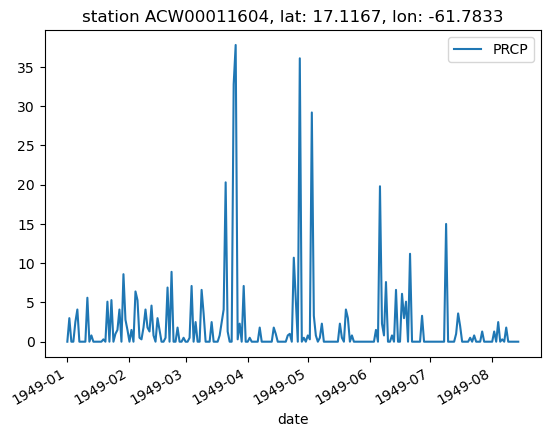

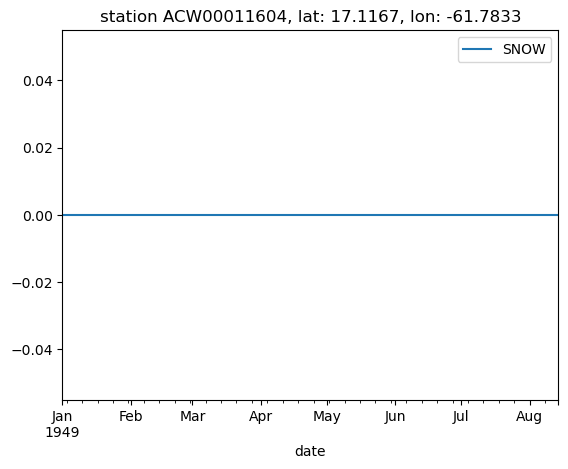

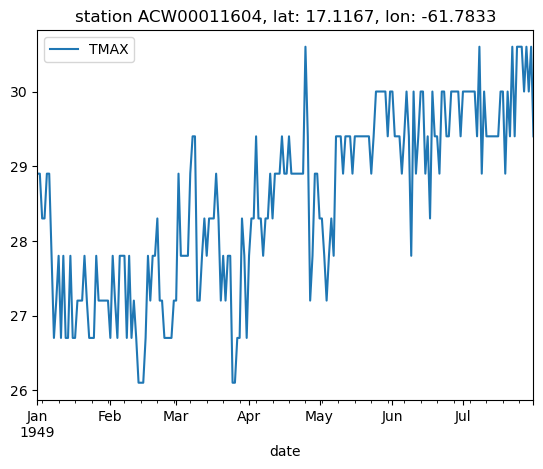

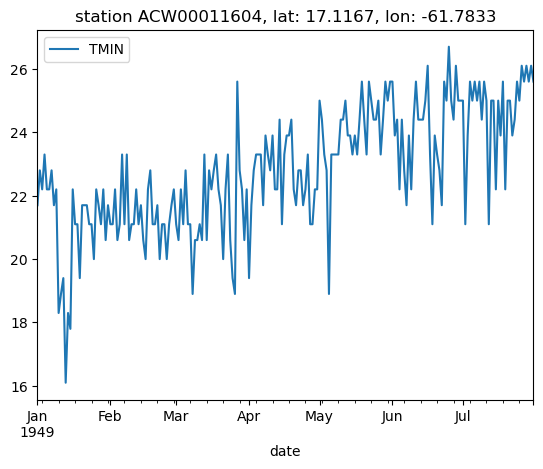

In [36]:
# plot timeseries of first station
first_station = df.loc[0, "stationcode"]
# reformat datelabels to datetime objects
df['date'] = pd.to_datetime(df["datelabel"], format="%Y%m%d")
# extract timeseries of the different parameters
ts = df.loc[df["stationcode"]==first_station, ["param", "date", "value"]].groupby(["param"])
# create plot
# construct a title string
stationmeta = stations[stations["code"]==first_station]
title = f"station {stationmeta['code'][0]}, lat: {stationmeta['lat'][0]}, lon: {stationmeta['lon'][0]}"
for name, gdata in ts:
    gdata.plot(x="date", y="value", title=title, label=name[0])